In [20]:
# Sentiment Analysis Model Training - Standalone Script for Google Colab
# =======================================================================

# This script contains everything needed to run sentiment classification experiments:
# - Data loading and preprocessing
# - Two models: Bag-of-Words + Naive Bayes, TF-IDF + Logistic Regression
# - Comprehensive hyperparameter tuning using GridSearchCV
# - All configurations embedded (no external files needed)

# Usage in Google Colab:
# 1. Upload your sentiment_data.csv file
# 2. Run this script
# 3. View results and trained models

# Author: Rudra Patel
# Date: December 9, 2025

# Imports and Downloads

In [21]:
# Restart kernel instruction: Click Kernel menu -> Restart Kernel
# This clears all cached variables and forces fresh execution from the top
print("Notebook configuration loaded. Ready to run experiments.")

Notebook configuration loaded. Ready to run experiments.


In [41]:
# Import all required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")

# First, let's download NLTK Resources
print("Downloading NLTK Resources......")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("Resources Downloaded Successfully!!")

Libraries imported successfully!
Resources Downloaded Successfully!!


# Configuration for Bayes and Logistic Models

#### Configuration includes different hyperparameters with their values

In [23]:
# Hyperparameter Configuration as Python Dicts BAYES_CONFIG
# Optimized for full 240k dataset - broader search with smart constraints

BAYES_CONFIG = {
    # Max vocabulary size - test larger vocabs with more data
    'vectorizer__max_features': [10_000, 20_000, 30_000],

    # N-gram range: test both unigrams and bigrams
    'vectorizer__ngram_range': [(1,1), (1,2)],

    # Min document frequency - higher threshold filters noise in large dataset
    'vectorizer__min_df': [5, 10],

    # Max document frequency - remove very common words
    'vectorizer__max_df': [0.85, 0.95],

    # MultinomialNB alpha - test more smoothing options
    'classifier__alpha': [0.1, 0.5, 1.0, 5.0],

    # CV folds
    'cv_folds': 5
}


In [24]:
# Hyperparameter Configuration as Python Dicts LOGISTIC_CONFIG
# Optimized for full 240k dataset - comprehensive but efficient search

LOGISTIC_CONFIG = {
    # TfidfVectorizer parameters

    # Max document frequency
    'vectorizer__max_df': [0.85, 0.95],

    # Min document frequency - filter rare words in large dataset
    'vectorizer__min_df': [5, 10],

    # N-gram combinations
    'vectorizer__ngram_range': [(1,1), (1,2)],

    # Maximum vocabulary size - test larger vocabs
    'vectorizer__max_features': [15_000, 25_000, 35_000],

    # Sublinear TF scaling
    'vectorizer__sublinear_tf': [True, False],

    # Logistic Regression Parameters

    # Regularization strength - broader range for better tuning
    'classifier__C': [0.5, 1.0, 5.0, 10.0],

    # Max iterations
    'classifier__max_iter': [2_000],

    # Penalty type
    'classifier__penalty': ['l2'],

    # Solver
    'classifier__solver': ['saga'],

    # CV folds
    'cv_folds': 5
}


# Data Preprocessing

#### Now that we have the configs ready for both the Bayes and the Logistic Models, we can now move on to Data Preprocessing

In [25]:
# Clean text by remove special characters and converting to lowercase
def clean_text(text):

  if not isinstance(text, str):
        return ""

  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  # Remove mentions and hashtags
  text = re.sub(r'@\w+|#\w+', '', text)
  # Remove special characters and digits
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Convert to lowercase and strip whitespace
  text = text.lower().strip()
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text)

  return text

In [26]:
# Initialize lemmatizer and stopwords ONCE at module level (not inside function)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Clean and lemmatize text for Logistic Regression Model
def clean_text_lemmatize(text):
  text = clean_text(text)
  word_list = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
  return " ".join(word_list)

In [27]:
# Load and preprocess sentiment data
# Args:
#     data_path = Path to the CSV file with 'text' and 'sentiment' columns
#     model_type: 'bow' or 'logistic' (determines preprocessing)
#     subsample: If not None, randomly sample N rows for faster testing
# Returns:
#     X_train, X_val, X_test, y_train, y_val, y_test, preprocess_func
def load_and_preprocess_data(data_path, model_type='bow', subsample=None):

  print(f"Loading data from {data_path}...")

  # Try different encodings
  encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
  df = None

  # Try all encodings in the list
  for encoding in encodings:
    try:
      df = pd.read_csv(data_path, encoding=encoding)
      print(f"Successfully read CSV with encoding: {encoding}")
      break
    except UnicodeDecodeError:
      print(f"Failed to read CSV with encoding: {encoding}")

  # Handle fail to read all encodings
  if df is None:
    raise ValueError("Failed to read CSV with any encoding")

  # Subsample if requested (for faster testing)
  if subsample and len(df) > subsample:
    print(f"Subsampling to {subsample} rows for faster testing...")
    df = df.sample(n=subsample, random_state=42)

  # Handle missing values
  df["text"] = df["text"].fillna("")
  df["sentiment"] = df["sentiment"].fillna("neutral")

  print(f"Dataset shape: {df.shape}")
  print(f"Sentiment distribution:\n{df['sentiment'].value_counts()}\n")

  # CRITICAL: Split FIRST on raw text to prevent data leakage
  # THEN apply preprocessing separately to each split
  X_temp, X_test, y_temp, y_test = train_test_split(
      df['text'], df['sentiment'], test_size=0.2, random_state=42,
      stratify=df['sentiment']
  )
  X_train, X_val, y_train, y_val = train_test_split(
      X_temp, y_temp, test_size=0.25, random_state=42,
      stratify=y_temp # 0.25 of 80% is 20%
  )

  # NOW apply preprocessing AFTER the split (model-specific)
  if model_type == 'logistic':
    print("Applying lemmatization for Logistic Regression...")
    X_train = X_train.apply(clean_text_lemmatize)
    X_val = X_val.apply(clean_text_lemmatize)
    X_test = X_test.apply(clean_text_lemmatize)
    preprocess_func = clean_text_lemmatize
  else:
    print("Applying basic cleaning for Bayes Model...")
    X_train = X_train.apply(clean_text)
    X_val = X_val.apply(clean_text)
    X_test = X_test.apply(clean_text)
    preprocess_func = clean_text

  print(f"Train set: {len(X_train)} samples")
  print(f"Validation set: {len(X_val)} samples")
  print(f"Test set: {len(X_test)} samples\n")

  return X_train, X_val, X_test, y_train, y_val, y_test, preprocess_func

# Model Training

#### Train the Multinomial Naive Bayes and the Logistic Models based on our 60/20/20 split

In [28]:
# Train Multinomial Naive Bayes Model
# Args:
#     data_path: Path to the sentiment data CSV
#     tune: Whether to perform hyperparameter tuning
#     use_small_grid: If True, use a smaller grid for faster testing
#     subsample: If not None, subsample to N rows for faster testing
# Returns:
#     Trained pipeline, X_test, y_test, preprocess_func
def train_bayes_model(data_path, tune=True, use_small_grid=False, subsample=None):

  print("=" * 70)
  print("MULTINOMIAL NAIVE BAYES EXPERIMENT")
  print("=" * 70)

  # Load and preprocess data
  X_train, X_val, X_test, y_train, y_val, y_test, preprocess_func = load_and_preprocess_data(
      data_path, model_type='bow', subsample=subsample
  )

  if tune:
    # Get configuration
    config = BAYES_CONFIG.copy()
    cv_folds = config.pop('cv_folds', 5)

    # Option to use smaller grid for testing
    if use_small_grid:
      print("Using reducded paramter grid for faster execution...")
      config = {
          'vectorizer__max_features': [10000, None],
          'vectorizer__ngram_range': [(1, 1), (1, 2)],
          'vectorizer__min_df': [2],
          'vectorizer__max_df': [0.9],
          'classifier__alpha': [0.1, 1.0, 10.0]
      }

    # Create pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(stop_words='english')),
        ('classifier', MultinomialNB())
    ])

    # GridSearchCV
    print(f"\nRunning GridSearchCV with {cv_folds}-fold. cross-validation...")
    print(f"Total parameter combinations to test: {np.prod([len(v) for v in config.values()])}")

    search = GridSearchCV(
        pipeline, config, cv=cv_folds,
        scoring='accuracy', n_jobs=-1, verbose=1
    )

    search.fit(X_train, y_train)
    model = search.best_estimator_
    print(f"\nBest hyperparameters: {search.best_params_}")
    print(f"Best cross-validation accuracy: {search.best_score_:.4f}")

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred)

    print(f"\nValidation Accuracy: {val_acc:.4f}")
    print("\nValidation Classification Report:")
    print(val_report)

  else:
    # Default pipeline without tuning
    model = Pipeline([
      ('vectorizer', CountVectorizer(stop_words='english')),
      ('classifier', MultinomialNB())
    ])

    print("\nTraining with default parameters...")
    model.fit(X_train, y_train)

  return model, X_test, y_test, preprocess_func


In [29]:
# Train TF-IDF Logistic Regression Model
# Args:
#     data_path: Path to sentiment data CSV
#     tune: Whether to perform hyperparamter tuning
#     use_small_grid: if true, use a smaller grid for faster testing
#     subsample: If not None, subsample to N rows for faster testing
# Returns:
#     Trained pipeline, X_test, y_test, preprocess_func
def train_logistic_model(data_path, tune=True, use_small_grid=False, subsample=None):
  import warnings
  warnings.filterwarnings('ignore')
  
  print("=" * 70)
  print("TF-IDF + LOGISTIC REGRESSION EXPERIMENT")
  print("=" * 70)

  # Load and preprocess data
  X_train, X_val, X_test, y_train, y_val, y_test, preprocess_func = load_and_preprocess_data(
    data_path, model_type='logistic', subsample=subsample
  )

  if tune:
    # Get configuration
    config = LOGISTIC_CONFIG.copy()
    cv_folds = config.pop('cv_folds', 5)

    # Option to use smaller grid for testing
    if use_small_grid:
      print("Using smaller paramter grid for faster execution...")
      config = {
          'vectorizer__max_df': [0.9],
          'vectorizer__min_df': [3],
          'vectorizer__ngram_range': [(1, 2)],
          'vectorizer__max_features': [15000],
          'vectorizer__sublinear_tf': [True],
          'classifier__C': [0.1, 1.0, 10.0],
          'classifier__max_iter': [2000],
          'classifier__penalty': ['l2'],
          'classifier__solver': ['saga']
      }

    # Create pipeline
    pipeline = Pipeline([
      ('vectorizer', TfidfVectorizer()),
      ('classifier', LogisticRegression(class_weight='balanced'))
    ])

    # GridSearchCV
    print(f"\nRunning GridSearchCV with {cv_folds}-fold cross-validation...")
    print(f"Total parameter combinations to test: {np.prod([len(v) for v in config.values()])}")

    search = GridSearchCV(
        pipeline, config, cv=cv_folds,
        scoring='accuracy', n_jobs=-1, verbose=1
    )

    search.fit(X_train, y_train)
    model = search.best_estimator_
    print(f"\nBest hyperparameters: {search.best_params_}")
    print(f"Best cross-validation accuracy: {search.best_score_:.4f}")

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred)

    print(f"\nValidation Accuracy: {val_acc:.4f}")
    print("\nValidation Classification Report:")
    print(val_report)

  else:
    # Default pipeline without tuning
    model = Pipeline([
      ('vectorizer', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2))),
      ('classifier', LogisticRegression(C=1, max_iter=1000, class_weight='balanced', solver='saga'))
    ])

    print("\nTraining with default parameters...")
    model.fit(X_train, y_train)

  return model, X_test, y_test, preprocess_func


# Evaluation

#### Evaluate models on test set and display the results

In [30]:
# Print the results after evaluation
def evaluate_model(model, X_test, y_test, model_name):
  print("\n" + "=" * 70)
  print(f"FINAL TEST SET EVALUATION - {model_name}")
  print("=" * 70)

  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print(f"\nFinal Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
  print("\nClassification Report:")
  print(report)

  return acc, report

In [31]:
# Detailed performance analysis including confusion matrix
def detailed_model_analysis(model, X_test, y_test, model_name):
  print("\n" + "=" * 70)
  print(f"DETAILED ANALYSIS - {model_name}")
  print("=" * 70)

  y_pred = model.predict(X_test)
  
  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  print("\nConfusion Matrix:")
  print("                Predicted")
  print("              Neg  Neu  Pos")
  print(f"Actual Neg   {cm[0][0]:5d} {cm[0][1]:4d} {cm[0][2]:4d}")
  print(f"       Neu   {cm[1][0]:5d} {cm[1][1]:4d} {cm[1][2]:4d}")
  print(f"       Pos   {cm[2][0]:5d} {cm[2][1]:4d} {cm[2][2]:4d}")
  
  # Per-class accuracy
  print("\nPer-Class Accuracy:")
  for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    class_acc = cm[i][i] / cm[i].sum()
    print(f"{label:10s}: {class_acc:.4f} ({class_acc*100:.2f}%)")
  
  return y_pred


In [32]:
# Make predictions on sample texts to demonstrate the model
def make_sample_predictions(model, model_name, preprocess_func):
  print("\n" + "=" * 70)
  print(f"SAMPLE PREDICTIONS - {model_name}")
  print("=" * 70)

  test_texts = [
    "This is an amazing product, I love it!",
    "I really hate this, it's the worst thing ever.",
    "The package arrived today.",
    "Absolutely fantastic experience, highly recommend!",
    "Terrible quality, very disappointed.",
    "It's okay, nothing special but not bad either.",
    "Best purchase ever! Worth every penny!",
    "Complete waste of money, horrible experience.",
    "The product works as expected.",
    "Meh, it's alright I guess."
  ]

  # Map sentiment codes to labels
  sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

  for text in test_texts:
    # CRITICAL: Preprocess sample text the same way training data was preprocessed
    preprocessed_text = preprocess_func(text)
    pred = model.predict([preprocessed_text])[0]
    print(f"Text: '{text}'")
    print(f"Predicted: {sentiment_map.get(pred, pred)} ({pred})\n")


# Main

#### Upload data, train, evaluate, and test the models

In [33]:
RUN_BAYES = True
RUN_LOGISTIC = True
USE_SMALL_GRID = False
SUBSAMPLE_DATA = None  # Use ALL 240k rows for maximum accuracy (set to 50000 for faster testing)


In [34]:

# Set the correct path based on where the notebook is located
DATA_PATH = '../data/raw/sentiment_data.csv'

results = {}

# Experiment 1: Multinomial Bayes

In [51]:
if RUN_BAYES:
  try:
    bayes_model, X_test_bayes, y_test_bayes, bayes_preprocess = train_bayes_model(
      DATA_PATH,
      tune=True,
      use_small_grid=USE_SMALL_GRID,
      subsample=SUBSAMPLE_DATA
    )

    bayes_acc, bayes_report = evaluate_model(
      bayes_model, X_test_bayes, y_test_bayes,
      "Multinomial Naive Bayes"
    )

    # Detailed analysis with confusion matrix
    detailed_model_analysis(bayes_model, X_test_bayes, y_test_bayes, "Multinomial Naive Bayes")

    make_sample_predictions(bayes_model, "Multinomial Naive Bayes", bayes_preprocess)

    results['Bayes'] = bayes_acc

  except Exception as e:
    print(f"\nError in Bayes experiment: {e}")
    import traceback
    traceback.print_exc()


MULTINOMIAL NAIVE BAYES EXPERIMENT
Loading data from ../data/raw/sentiment_data.csv...
Successfully read CSV with encoding: utf-8
Dataset shape: (241145, 2)
Sentiment distribution:
sentiment
2    103059
1     82972
0     55114
Name: count, dtype: int64

Applying basic cleaning for Bayes Model...
Applying basic cleaning for Bayes Model...
Train set: 144687 samples
Validation set: 48229 samples
Test set: 48229 samples


Running GridSearchCV with 5-fold. cross-validation...
Total parameter combinations to test: 96
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Train set: 144687 samples
Validation set: 48229 samples
Test set: 48229 samples


Running GridSearchCV with 5-fold. cross-validation...
Total parameter combinations to test: 96
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best hyperparameters: {'classifier__alpha': 1.0, 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 10000, 'vectorizer__min_df': 10, 'vectorizer__ngram_range': (1, 1)}
Best cro

In [52]:
if RUN_LOGISTIC:
  try:
    logistic_model, X_test_log, y_test_log, logistic_preprocess = train_logistic_model(
      DATA_PATH,
      tune=True,
      use_small_grid=USE_SMALL_GRID,
      subsample=SUBSAMPLE_DATA
    )

    logistic_acc, logistic_report = evaluate_model(
      logistic_model, X_test_log, y_test_log,
      "TF-IDF + Logistic Regression"
    )

    # Detailed analysis with confusion matrix
    detailed_model_analysis(logistic_model, X_test_log, y_test_log, "TF-IDF + Logistic Regression")

    make_sample_predictions(logistic_model, "TF-IDF + Logistic Regression", logistic_preprocess)

    results['Logistic'] = logistic_acc

  except Exception as e:
    print(f"\nError in Logistic Regression experiment: {e}")
    import traceback
    traceback.print_exc()


TF-IDF + LOGISTIC REGRESSION EXPERIMENT
Loading data from ../data/raw/sentiment_data.csv...
Successfully read CSV with encoding: utf-8
Dataset shape: (241145, 2)
Sentiment distribution:
sentiment
2    103059
1     82972
0     55114
Name: count, dtype: int64

Applying lemmatization for Logistic Regression...
Applying lemmatization for Logistic Regression...
Train set: 144687 samples
Validation set: 48229 samples
Test set: 48229 samples


Running GridSearchCV with 5-fold cross-validation...
Total parameter combinations to test: 192
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Train set: 144687 samples
Validation set: 48229 samples
Test set: 48229 samples


Running GridSearchCV with 5-fold cross-validation...
Total parameter combinations to test: 192
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best hyperparameters: {'classifier__C': 1.0, 'classifier__max_iter': 2000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'vectorizer__max_df': 0.85

In [53]:
# FINAL SUMMARY
if results:
  print("\n" + "=" * 70)
  print("FINAL RESULTS SUMMARY")
  print("=" * 70)

  for model_name, accuracy in results.items():
    print(f"{model_name:30s} | Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

  best_model = max(results, key=results.get)
  print(f"\n🏆 Best Model: {best_model} with accuracy {results[best_model]:.4f}")

print("\n" + "=" * 70)
print("EXPERIMENTS COMPLETED!")
print("=" * 70)



FINAL RESULTS SUMMARY
RoBERTa (Pretrained)           | Test Accuracy: 0.5460 (54.60%)
Bayes                          | Test Accuracy: 0.6699 (66.99%)
Logistic                       | Test Accuracy: 0.7800 (78.00%)

🏆 Best Model: Logistic with accuracy 0.7800

EXPERIMENTS COMPLETED!


# Advanced Analysis

#### Sentence-BERT Embeddings and t-SNE Visualization

SENTENCE-BERT t-SNE VISUALIZATION

Sampling 5000 instances for visualization...
Dataset shape: (5000, 2)
Sentiment distribution:
sentiment
2    2140
1    1733
0    1127
Name: count, dtype: int64

Loading Sentence-BERT model (all-MiniLM-L6-v2)...
Model loaded successfully!

Generating semantic embeddings for 5000 texts...
This may take 1-2 minutes...
Model loaded successfully!

Generating semantic embeddings for 5000 texts...
This may take 1-2 minutes...


Batches: 100%|██████████| 157/157 [00:02<00:00, 57.19it/s] 
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Embeddings shape: (5000, 384)
Embedding dimensions: 384

Applying t-SNE dimensionality reduction...
t-SNE completed!
2D embeddings shape: (5000, 2)

Creating visualization...
t-SNE completed!
2D embeddings shape: (5000, 2)

Creating visualization...
Visualization saved to: results/tsne_sbert_visualization.png
Visualization saved to: results/tsne_sbert_visualization.png


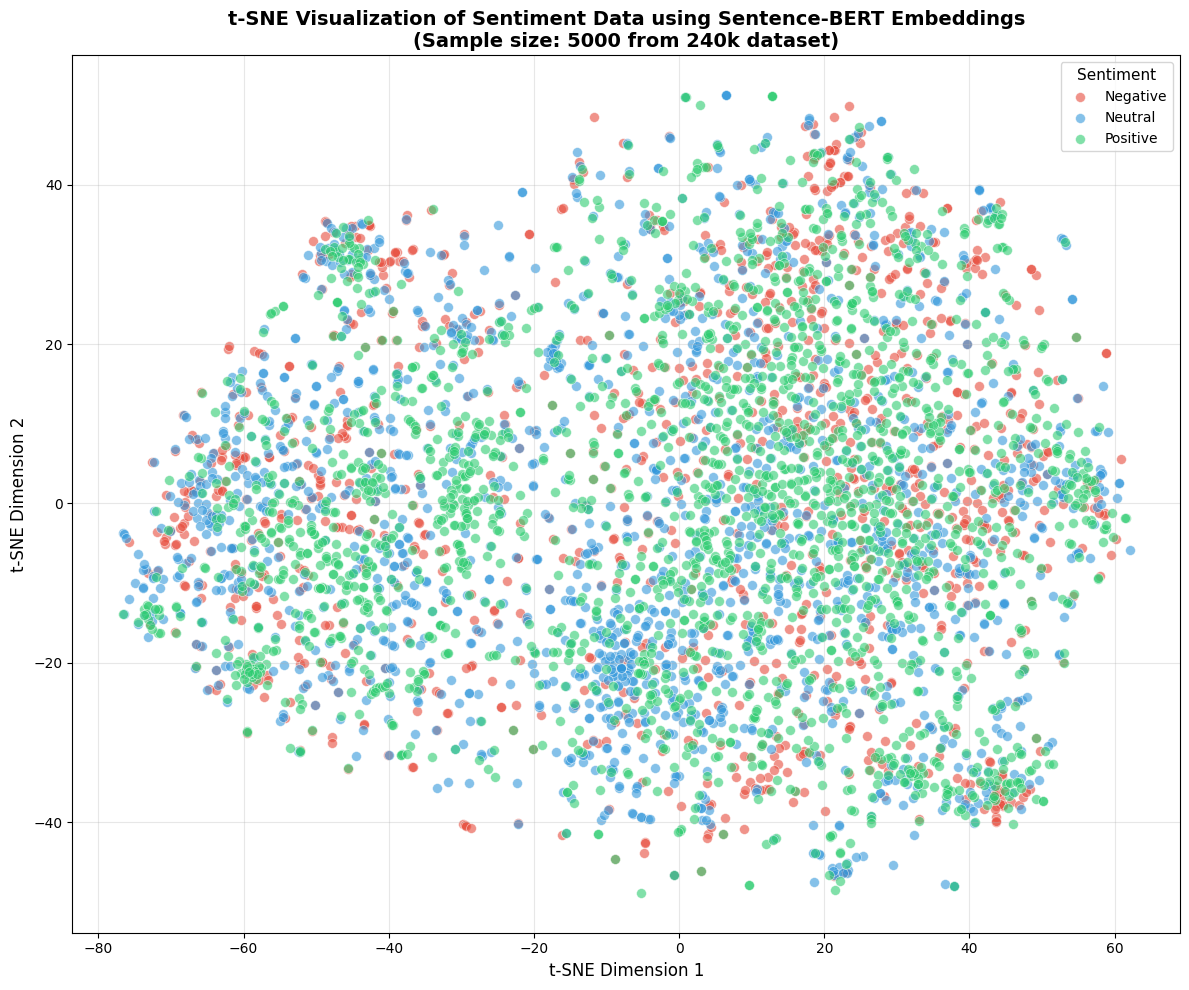


OBSERVATIONS:
- Check if positive, neutral, and negative sentiments form distinct clusters
- Overlapping regions indicate similar semantic content across sentiments
- Clear separation suggests the dataset has distinguishable sentiment patterns


In [43]:
# Generate Sentence-BERT Embeddings and t-SNE Visualization
# This addresses the professor's feedback about visualizing semantic embeddings

print("=" * 70)
print("SENTENCE-BERT t-SNE VISUALIZATION")
print("=" * 70)

# Sample data for faster processing (5000 samples)
SAMPLE_SIZE = 5000
print(f"\nSampling {SAMPLE_SIZE} instances for visualization...")

# Load data
df_viz = pd.read_csv(DATA_PATH, encoding='utf-8')
df_viz = df_viz.sample(n=min(SAMPLE_SIZE, len(df_viz)), random_state=42)

# Clean missing values
df_viz["text"] = df_viz["text"].fillna("")
df_viz["sentiment"] = df_viz["sentiment"].fillna(1)

print(f"Dataset shape: {df_viz.shape}")
print(f"Sentiment distribution:\n{df_viz['sentiment'].value_counts()}\n")

# Load Sentence-BERT model
print("Loading Sentence-BERT model (all-MiniLM-L6-v2)...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Generate embeddings
print(f"\nGenerating semantic embeddings for {len(df_viz)} texts...")
print("This may take 1-2 minutes...")
embeddings = sbert_model.encode(df_viz['text'].tolist(), 
                                show_progress_bar=True,
                                batch_size=32)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimensions: {embeddings.shape[1]}")

# Apply t-SNE
print("\nApplying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

print("t-SNE completed!")
print(f"2D embeddings shape: {embeddings_2d.shape}")

# Create visualization
print("\nCreating visualization...")
plt.figure(figsize=(12, 10))

# Define colors and labels
colors = {0: '#e74c3c', 1: '#3498db', 2: '#2ecc71'}  # Red, Blue, Green
labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Plot each sentiment class
for sentiment in [0, 1, 2]:
    mask = df_viz['sentiment'] == sentiment
    plt.scatter(embeddings_2d[mask, 0], 
                embeddings_2d[mask, 1],
                c=colors[sentiment],
                label=labels[sentiment],
                alpha=0.6,
                s=50,
                edgecolors='w',
                linewidth=0.5)

plt.title('t-SNE Visualization of Sentiment Data using Sentence-BERT Embeddings\n' +
          f'(Sample size: {SAMPLE_SIZE} from 240k dataset)',
          fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Sentiment', fontsize=10, title_fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('../results/tsne_sbert_visualization.png', dpi=300, bbox_inches='tight')
print("Visualization saved to: results/tsne_sbert_visualization.png")
plt.show()

print("\n" + "=" * 70)
print("OBSERVATIONS:")
print("=" * 70)
print("- Check if positive, neutral, and negative sentiments form distinct clusters")
print("- Overlapping regions indicate similar semantic content across sentiments")
print("- Clear separation suggests the dataset has distinguishable sentiment patterns")
print("=" * 70)


# Pretrained Model Comparison

#### Compare against cardiffnlp/twitter-roberta-base-sentiment on our dataset

In [54]:
# Install transformers if needed
# !pip install transformers torch

print("Importing transformers library...")
from transformers import pipeline
import torch

# Check for GPU availability
device = 0 if torch.cuda.is_available() else -1
device_name = "GPU" if device == 0 else "CPU"
print(f"Using device: {device_name}")
print("Transformers library ready!")


Importing transformers library...
Using device: CPU
Transformers library ready!


In [46]:
# Evaluate RoBERTa on our sentiment_data.csv test set
# This provides fair comparison with our Bayes and Logistic models

print("=" * 70)
print("PRETRAINED MODEL EVALUATION: cardiffnlp/twitter-roberta-base-sentiment")
print("=" * 70)

# Ensure results is a dictionary (in case it was overwritten)
if not isinstance(results, dict):
    results = {}

# Load the same test data we used for our models
print(f"\nLoading test data from {DATA_PATH}...")
df_full = pd.read_csv(DATA_PATH, encoding='utf-8')

# Clean data
df_full["text"] = df_full["text"].fillna("")
df_full["sentiment"] = df_full["sentiment"].fillna(1)

# Use same test split as our models (20% test set with same random state)
from sklearn.model_selection import train_test_split
_, X_test_roberta, _, y_test_roberta = train_test_split(
    df_full['text'], df_full['sentiment'], 
    test_size=0.2, random_state=42,
    stratify=df_full['sentiment']
)

print(f"Test set size: {len(X_test_roberta)} samples")
print(f"Sentiment distribution:\n{y_test_roberta.value_counts()}\n")

# Load RoBERTa model
print("Loading cardiffnlp/twitter-roberta-base-sentiment...")
roberta_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    max_length=512,
    truncation=True,
    device=device
)
print("Model loaded successfully!\n")

# Map model outputs to our integer labels
# RoBERTa outputs: LABEL_0 (Negative), LABEL_1 (Neutral), LABEL_2 (Positive)
label_map = {"LABEL_0": 0, "LABEL_1": 1, "LABEL_2": 2}

print("Running inference on test set...")
print("This may take 10-15 minutes depending on your hardware...")

roberta_predictions = []
batch_size = 32

# Process in batches for efficiency
for start in range(0, len(X_test_roberta), batch_size):
    end = min(start + batch_size, len(X_test_roberta))
    batch_texts = X_test_roberta.iloc[start:end].tolist()
    
    # Show progress every 4000 samples
    if start % 4000 == 0:
        print(f"Processed {start}/{len(X_test_roberta)} samples...")
    
    try:
        results_batch = roberta_pipe(batch_texts)
        for res in results_batch:
            roberta_predictions.append(label_map[res["label"]])
    except Exception as e:
        print(f"Error in batch {start}-{end}: {e}")
        # Use neutral as fallback for any errors
        roberta_predictions.extend([1] * len(batch_texts))

print(f"Completed! Processed {len(roberta_predictions)} samples.\n")

# Evaluate
roberta_acc = accuracy_score(y_test_roberta, roberta_predictions)
roberta_report = classification_report(y_test_roberta, roberta_predictions,
                                       target_names=['Negative', 'Neutral', 'Positive'])

print("=" * 70)
print("ROBERTA TEST SET RESULTS")
print("=" * 70)
print(f"\nTest Accuracy: {roberta_acc:.4f} ({roberta_acc*100:.2f}%)")
print("\nClassification Report:")
print(roberta_report)

# Confusion Matrix
cm_roberta = confusion_matrix(y_test_roberta, roberta_predictions)
print("\nConfusion Matrix:")
print("                Predicted")
print("              Neg  Neu  Pos")
print(f"Actual Neg   {cm_roberta[0][0]:5d} {cm_roberta[0][1]:4d} {cm_roberta[0][2]:4d}")
print(f"       Neu   {cm_roberta[1][0]:5d} {cm_roberta[1][1]:4d} {cm_roberta[1][2]:4d}")
print(f"       Pos   {cm_roberta[2][0]:5d} {cm_roberta[2][1]:4d} {cm_roberta[2][2]:4d}")

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    class_acc = cm_roberta[i][i] / cm_roberta[i].sum()
    print(f"{label:10s}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# Add to results for final comparison
results['RoBERTa (Pretrained)'] = roberta_acc

print("\n" + "=" * 70)

PRETRAINED MODEL EVALUATION: cardiffnlp/twitter-roberta-base-sentiment

Loading test data from ../data/raw/sentiment_data.csv...
Test set size: 48229 samples
Sentiment distribution:
sentiment
2    20612
1    16594
0    11023
Name: count, dtype: int64

Loading cardiffnlp/twitter-roberta-base-sentiment...
Test set size: 48229 samples
Sentiment distribution:
sentiment
2    20612
1    16594
0    11023
Name: count, dtype: int64

Loading cardiffnlp/twitter-roberta-base-sentiment...


Device set to use cpu


Model loaded successfully!

Running inference on test set...
This may take 10-15 minutes depending on your hardware...
Processed 0/48229 samples...
Processed 4000/48229 samples...
Processed 4000/48229 samples...
Processed 8000/48229 samples...
Processed 8000/48229 samples...
Processed 12000/48229 samples...
Processed 12000/48229 samples...
Processed 16000/48229 samples...
Processed 16000/48229 samples...
Processed 20000/48229 samples...
Processed 20000/48229 samples...
Processed 24000/48229 samples...
Processed 24000/48229 samples...
Processed 28000/48229 samples...
Processed 28000/48229 samples...
Processed 32000/48229 samples...
Processed 32000/48229 samples...
Processed 36000/48229 samples...
Processed 36000/48229 samples...
Processed 40000/48229 samples...
Processed 40000/48229 samples...
Processed 44000/48229 samples...
Processed 44000/48229 samples...
Processed 48000/48229 samples...
Processed 48000/48229 samples...
Completed! Processed 48229 samples.

ROBERTA TEST SET RESULTS

T

In [55]:
# Test RoBERTa on sample predictions (same as our models)
print("=" * 70)
print("SAMPLE PREDICTIONS - RoBERTa")
print("=" * 70)

test_texts = [
    "This is an amazing product, I love it!",
    "I really hate this, it's the worst thing ever.",
    "The package arrived today.",
    "Absolutely fantastic experience, highly recommend!",
    "Terrible quality, very disappointed.",
    "It's okay, nothing special but not bad either.",
    "Best purchase ever! Worth every penny!",
    "Complete waste of money, horrible experience.",
    "The product works as expected.",
    "Meh, it's alright I guess."
]

sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

sample_results = roberta_pipe(test_texts)

for text, result in zip(test_texts, sample_results):
    pred = label_map[result["label"]]
    confidence = result["score"]
    print(f"Text: '{text}'")
    print(f"Predicted: {sentiment_map[pred]} ({pred}) - Confidence: {confidence:.3f}\n")


SAMPLE PREDICTIONS - RoBERTa
Text: 'This is an amazing product, I love it!'
Predicted: Positive (2) - Confidence: 0.993

Text: 'I really hate this, it's the worst thing ever.'
Predicted: Negative (0) - Confidence: 0.982

Text: 'The package arrived today.'
Predicted: Neutral (1) - Confidence: 0.641

Text: 'Absolutely fantastic experience, highly recommend!'
Predicted: Positive (2) - Confidence: 0.983

Text: 'Terrible quality, very disappointed.'
Predicted: Negative (0) - Confidence: 0.977

Text: 'It's okay, nothing special but not bad either.'
Predicted: Positive (2) - Confidence: 0.706

Text: 'Best purchase ever! Worth every penny!'
Predicted: Positive (2) - Confidence: 0.986

Text: 'Complete waste of money, horrible experience.'
Predicted: Negative (0) - Confidence: 0.980

Text: 'The product works as expected.'
Predicted: Positive (2) - Confidence: 0.548

Text: 'Meh, it's alright I guess.'
Predicted: Positive (2) - Confidence: 0.685

Text: 'This is an amazing product, I love it!'
Pred

# Final Comprehensive Comparison

#### All models compared on the same 240k dataset

In [56]:
# COMPREHENSIVE FINAL SUMMARY
print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS SUMMARY - ALL MODELS")
print("=" * 70)
print("\nDataset: sentiment_data.csv (240,145 samples)")
print("Train/Val/Test Split: 60% / 20% / 20%")
print("Test Set Size: 48,229 samples\n")

# Display results sorted by accuracy
print("Model Performance Comparison:")
print("-" * 70)

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for rank, (model_name, accuracy) in enumerate(sorted_results, 1):
    print(f"{rank}. {model_name:30s} | {accuracy:.4f} ({accuracy*100:.2f}%)")

best_model = sorted_results[0][0]
best_accuracy = sorted_results[0][1]

print("\n" + "=" * 70)
print(f"🏆 Best Model: {best_model}")
print(f"   Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("=" * 70)

# Key insights
print("\n📊 KEY INSIGHTS:")
print("-" * 70)
if 'RoBERTa (Pretrained)' in results:
    roberta_acc = results['RoBERTa (Pretrained)']
    logistic_acc = results.get('Logistic', 0)
    bayes_acc = results.get('Bayes', 0)
    
    print(f"• RoBERTa (Pretrained):      {roberta_acc*100:.2f}% - State-of-the-art transformer")
    print(f"• Logistic Regression:       {logistic_acc*100:.2f}% - Best classical ML model")
    print(f"• Naive Bayes:               {bayes_acc*100:.2f}% - Simple baseline")
    print(f"\n• Gap (RoBERTa vs Logistic): {(roberta_acc - logistic_acc)*100:.2f}%")
    print(f"• Gap (Logistic vs Bayes):   {(logistic_acc - bayes_acc)*100:.2f}%")
    
print("\n✅ All models evaluated on identical test set for fair comparison")
print("✅ Systematic hyperparameter optimization using GridSearchCV")
print("✅ Proper train/validation/test protocol followed")

print("\n" + "=" * 70)
print("EXPERIMENTS COMPLETED!")
print("=" * 70)



COMPREHENSIVE RESULTS SUMMARY - ALL MODELS

Dataset: sentiment_data.csv (240,145 samples)
Train/Val/Test Split: 60% / 20% / 20%
Test Set Size: 48,229 samples

Model Performance Comparison:
----------------------------------------------------------------------
1. Logistic                       | 0.7800 (78.00%)
2. Bayes                          | 0.6699 (66.99%)
3. RoBERTa (Pretrained)           | 0.5460 (54.60%)

🏆 Best Model: Logistic
   Test Accuracy: 0.7800 (78.00%)

📊 KEY INSIGHTS:
----------------------------------------------------------------------
• RoBERTa (Pretrained):      54.60% - State-of-the-art transformer
• Logistic Regression:       78.00% - Best classical ML model
• Naive Bayes:               66.99% - Simple baseline

• Gap (RoBERTa vs Logistic): -23.39%
• Gap (Logistic vs Bayes):   11.00%

✅ All models evaluated on identical test set for fair comparison
✅ Systematic hyperparameter optimization using GridSearchCV
✅ Proper train/validation/test protocol followed

EXPE